In [20]:
import numpy as np

from tqdm import tqdm
from PIL import Image
from mnist import MNIST

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
mnist = MNIST("MNIST")
class MNISTDataSet(Dataset):
    def __init__(self, path, train=True, transform=transforms.ToTensor()):
        self.path = path
        self.transform = transform
        self.images, self.labels = mnist.load_training() if train else mnist.load_testing()
        
        shape = (int(len(self.images[0])**.5), int(len(self.images[0])**.5))
        self.images = list(map(lambda img: np.array(img).reshape(*shape), self.images))
        
    def __len__(self): return len(self.labels)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.fromarray(np.uint8(img)).convert("L")
    
        if self.transform: img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

batch_size = 100
train_set = MNISTDataSet(mnist, True)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
test_set = MNISTDataSet(mnist, False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [3]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_a, hidden_b, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_a, bias=True)
        self.fc2 = nn.Linear(hidden_a, hidden_b, bias=True)
        self.fc3 = nn.Linear(hidden_b, num_classes, bias=True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [4]:
class CNN_fc(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_fc, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32*7*7, num_classes, bias=True)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [5]:
class CNN_conv(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_out = nn.Conv2d(32, num_classes, kernel_size=7, stride=1, padding=0)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.conv_out(x)
        
        return x

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.depth = depth
        self.rnn = nn.RNN(input_size, hidden_size, depth, batch_first=True)
        self.fc = nn.Linear(input_size*hidden_size, num_classes, bias=True)
        
    def forward(self, x):
        h0 = torch.zeros(self.depth, x.size(0), self.hidden_size).to(device)
        
        x, _ = self.rnn(x, h0)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [7]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.depth = depth
        self.gru = nn.GRU(input_size, hidden_size, depth, batch_first=True)
        self.fc = nn.Linear(input_size*hidden_size, num_classes, bias=True)
        
    def forward(self, x):
        h0 = torch.zeros(self.depth, x.size(0), self.hidden_size).to(device)
        
        x, _ = self.gru(x, h0)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.depth = depth
        self.lstm = nn.LSTM(input_size, hidden_size, depth, batch_first=True)
        self.fc = nn.Linear(input_size*hidden_size, num_classes, bias=True)
        
    def forward(self, x):
        h0 = torch.zeros(self.depth, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.depth, x.size(0), self.hidden_size).to(device)
        
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [9]:
import pandas as pd
df = pd.DataFrame(index=["DNN", "RNN", "GRU", "LSTM", "CNN_fc", "CNN_conv"])

In [10]:
device = torch.device("cpu")
model = DNN(28**2, 64, 32, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    for i, (X,y) in enumerate(tqdm(train_loader)):
        X = X.view(X.size(0), -1)
        X, y = X.to(device), y.to(device)
        
        score = model(X)
        loss = criterion(score, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X,y) in enumerate(tqdm(test_loader)):
        predict = model(X.reshape(X.size(0), -1)).max(-1)[1]
        accuracy.append(int((predict==y).sum() / batch_size * 100))
    df.loc["DNN", f"Epoch{epoch}"] = sum(accuracy) / len(test_loader)

  0%|          | 0/600 [00:00<?, ?it/s]/home/becode/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
100%|██████████| 100/100 [00:01<00:00, 83.28it/s]


In [11]:
device = torch.device("cpu")
model = RNN(28, 64, 10, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    for i, (X,y) in enumerate(tqdm(train_loader)):
        X = X.squeeze(1)
        X, y = X.to(device), y.to(device)
        
        score = model(X)
        loss = criterion(score, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X,y) in enumerate(tqdm(test_loader)):
        predict = model(X.squeeze(1)).max(-1)[1]
        accuracy.append(int((predict==y).sum() / batch_size * 100))
    df.loc["RNN", f"Epoch{epoch}"] = sum(accuracy) / len(test_loader)

100%|██████████| 100/100 [00:01<00:00, 52.34it/s]


In [12]:
device = torch.device("cpu")
model = GRU(28, 64, 10, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    for i, (X,y) in enumerate(tqdm(train_loader)):
        X = X.squeeze(1)
        X, y = X.to(device), y.to(device)
        
        score = model(X).reshape(X.size(0), -1)
        loss = criterion(score, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X,y) in enumerate(tqdm(test_loader)):
        predict = model(X.squeeze(1)).max(-1)[1]
        accuracy.append(int((predict==y).sum() / batch_size * 100))
    df.loc["GRU", f"Epoch{epoch}"] = sum(accuracy) / len(test_loader)

100%|██████████| 100/100 [00:03<00:00, 31.91it/s]


In [13]:
device = torch.device("cpu")
model = LSTM(28, 64, 10, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    for i, (X,y) in enumerate(tqdm(train_loader)):
        X = X.squeeze(1)
        X, y = X.to(device), y.to(device)
        
        score = model(X)
        loss = criterion(score, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X,y) in enumerate(tqdm(test_loader)):
        predict = model(X.squeeze(1)).max(-1)[1]
        accuracy.append(int((predict==y).sum() / batch_size * 100))
    df.loc["LSTM", f"Epoch{epoch}"] = sum(accuracy) / len(test_loader)

100%|██████████| 100/100 [00:03<00:00, 32.65it/s]


In [14]:
device = torch.device("cpu")
model = CNN_fc(1, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    for i, (X,y) in enumerate(tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        
        score = model(X)
        loss = criterion(score, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X,y) in enumerate(tqdm(test_loader)):
        predict = model(X).max(-1)[1]
        accuracy.append(int((predict==y).sum() / batch_size * 100))
    df.loc["CNN_fc", f"Epoch{epoch}"] = sum(accuracy) / len(test_loader)

100%|██████████| 100/100 [00:04<00:00, 23.45it/s]


In [39]:
device = torch.device("cpu")
model = CNN_conv(1, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    for i, (X,y) in enumerate(tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        
        score = model(X).reshape(X.size(0), -1)
        loss = criterion(score, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X,y) in enumerate(tqdm(test_loader)):
        predict = model(X).reshape(X.size(0), -1).max(-1)[1]
        accuracy.append(int((predict==y).sum() / batch_size * 100))
    df.loc["CNN_conv", f"Epoch{epoch}"] = sum(accuracy) / len(test_loader)

100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


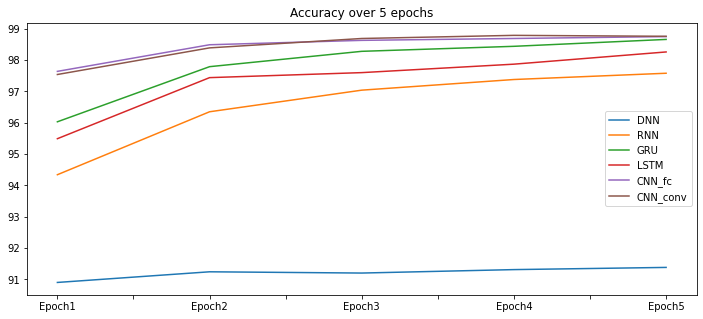

In [41]:
df.T.plot(figsize=(12,5))
plt.title("Accuracy over 5 epochs")
plt.show()

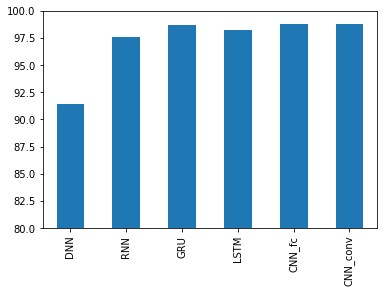

In [42]:
df.T.max().plot.bar()
plt.gca().set_ylim(80,100)
plt.show()

In [43]:
df.to_csv("accuracy.csv")

In [45]:
test = pd.read_csv("accuracy.csv", index_col=0)

,Epoch1,Epoch2,Epoch3,Epoch4,Epoch5
DNN,90.90,91.24,91.20,91.31,91.38
RNN,94.34,96.35,97.04,97.38,97.58
GRU,96.03,97.79,98.28,98.44,98.66
LSTM,95.49,97.44,97.60,97.87,98.26
CNN_fc,97.64,98.49,98.63,98.69,98.75
CNN_conv,97.54,98.39,98.69,98.79,98.76
